# Node classfication

In [1]:
cd ~/thesis

/home/jovyan/thesis


/home/jovyan/venvs/my_environment/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/jovyan/venvs/my_environment/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Import libraries

In [2]:
import pandas as pd
import networkx as nx

# Modify eliorc's implementation
from eliorc_mod.node2vec import Node2Vec
from gensim.models import Word2Vec

from utils import model_gen, plot_graph, ext_subgraph_modify, \
enhanced_ext_subgraph_func, connect_subgraph, groups_assign, \
train_test_creator, ovr_classifier

/tmp/ipykernel_1349/3159019958.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### BlogCatalog 

In [3]:
blog_dir = '/home/jovyan/thesis/datasets/blog_catalog/data/'

G = nx.read_edgelist(blog_dir+'edges.csv', delimiter=',')
G.name = 'blog_catalog'

# Groups mapping
group_df = pd.read_csv(blog_dir+'group-edges.csv', delimiter=',')
group_df.columns = ['node_num', 'group']

model = Word2Vec.load("models/blog_model")

groups_dict = {node_num: group_df.loc[node_num, 'group']  for node_num in group_df['node_num']}

# Create a dictionary to map node IDs to vectors
node_vectors = {}
for node_id in model.wv.index_to_key:
    node_vectors[int(node_id)] = model.wv.get_vector(node_id)

X = list(node_vectors.values())
y = [groups_dict[key] for key in node_vectors if key in groups_dict] # the mapping keeps the same order

# # Plot
# test_grid_search(G, X, y)

## Adding/removing nodes/edges

### Extending

#### Stochastic Block Model

In [69]:
sizes = [5, 5, 10]
probs = [[0.25, 0.05, 0.02],
         [0.05, 0.35, 0.07],
         [0.02, 0.07, 0.40]]

initial_graph = nx.stochastic_block_model(sizes, probs, seed=0)
# initial_graph.remove_nodes_from([0, 4])

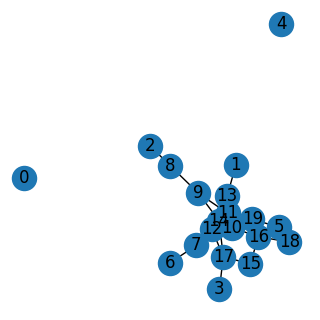

In [70]:
plot_graph(initial_graph)   

In [71]:
ext_subgraph = nx.erdos_renyi_graph(n=10, p=0.35, seed=12)

ext_subgraph = ext_subgraph_modify(initial_graph, ext_subgraph)

In [72]:
enh_ext_subgraph = enhanced_ext_subgraph_func(initial_graph, ext_subgraph, 8, 2)

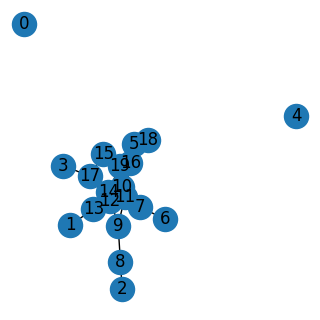

In [73]:
plot_graph(initial_graph)

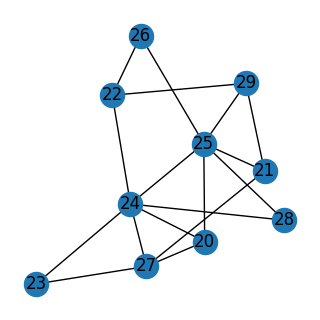

In [74]:
plot_graph(ext_subgraph)

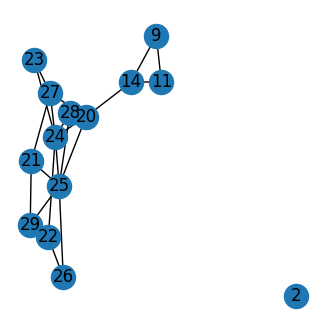

In [75]:
plot_graph(enh_ext_subgraph)

In [76]:
[node_main, node_sub], new_graph = connect_subgraph(initial_graph, ext_subgraph)

In [77]:
len(initial_graph.nodes()), len(initial_graph.edges())

(20, 27)

In [78]:
len(ext_subgraph.nodes()), len(ext_subgraph.edges())

(10, 17)

In [79]:
len(new_graph.nodes()), len(new_graph.edges())

(30, 45)

In [80]:
params = [64, 10, 80, 0.25, 4]

In [81]:
node2vec_initial, model_initial = model_gen(initial_graph, params)
model_initial.wv.vectors.shape

(20, 64)

In [82]:
node2vec_ext, model_ext = model_gen(ext_subgraph, params)
model_ext.wv.vectors.shape

(10, 64)

In [83]:
node2vec_new, model_new = model_gen(new_graph, params)
model_new.wv.vectors.shape

(30, 64)

In [84]:
groups_dict = groups_assign(initial_graph, ext_subgraph)

In [85]:
X_initial, y_initial, node_vectors_initial = train_test_creator(groups_dict, model_initial)

In [86]:
X_ext, y_ext, node_vectors_ext = train_test_creator(groups_dict, model_ext)

In [87]:
X_new, y_new, node_vectors_new = train_test_creator(groups_dict, model_new)

In [88]:
X_manual = X_initial + X_ext
y_manual = y_initial + y_ext

In [89]:
ovr_classifier(X_new, y_new, test_size=0.1)

{0.9: [0.0, 0.0]}

In [90]:
ovr_classifier(X_manual, y_manual, test_size=0.1)

{0.9: [0.3333333333333333, 0.2222222222222222]}

In [70]:
# test_grid_search(new_graph, X_fast, y_fast)
# test_grid_search(new_graph, X_new, y_new)

#### BlogCatalog

In [91]:
blog_dir = '/home/jovyan/thesis/datasets/blog_catalog/data/'

G = nx.read_edgelist(blog_dir+'edges.csv', delimiter=',')
G.name = 'blog_catalog'

# Groups mapping
group_df = pd.read_csv(blog_dir+'group-edges.csv', delimiter=',')
group_df.columns = ['node_num', 'group']

model = Word2Vec.load("models/blog_model")

groups_dict = groups_assign(G, ext_subgraph, group_df)

In [92]:
# Fill these similar to previous cells - make a function

## Finding nearby area of node

In [132]:
blog_dir = '/home/jovyan/thesis/datasets/blog_catalog/data/'

G = nx.read_edgelist(blog_dir+'edges.csv', delimiter=',')
G.name = 'blog_catalog'

# plt.figure(figsize=(3, 3))
# nx.draw(G, with_labels=True)
# plt.show()

In [133]:
len(get_neighborhood(G, '1', 1).nodes())

119

In [137]:
len(get_neighborhood(G, '1', 2).nodes())

9554

In [27]:
G = nx.random_regular_graph(3, 40, seed=10)

# plt.figure(figsize=(3, 3))
# nx.draw(G, with_labels=True)
# plt.show()

In [142]:
list(get_neighborhood(G, 0, 1))

[25, 4, 15]

In [143]:
list(get_neighborhood(G, 0, 3))

[0, 33, 34, 4, 36, 6, 7, 37, 38, 14, 15, 16, 18, 22, 25, 27, 29, 31]

### Pruning

#### BlogCatalog

In [31]:
blog_dir = '/home/jovyan/thesis/datasets/blog_catalog/data/'

# blog_dir = 'datasets/blog_catalog/data/'

G = nx.read_edgelist(blog_dir+'edges.csv', delimiter=',')
G.name = 'blog_catalog'

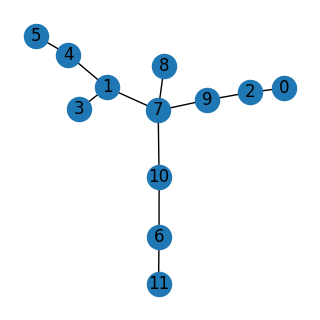

In [72]:
G = nx.random_tree(12, seed=1)

plt.figure(figsize=(3, 3))
nx.draw(G, with_labels=True)
plt.show()

In [73]:
graph, removed_nodes = remove_nodes_connected(G, 3)
removed_nodes

[8, 5, 0]

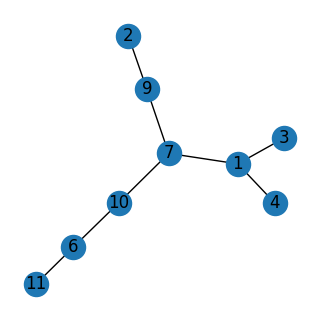

In [76]:
plt.figure(figsize=(3, 3))
nx.draw(graph, with_labels=True)
plt.show()

In [81]:
neighbors = []

for node in removed_nodes: 
    neighbors += list(get_neighborhood(G, node, 2))

In [82]:
neighbors

[1, 10, 9, 7, 1, 4, 9, 2]

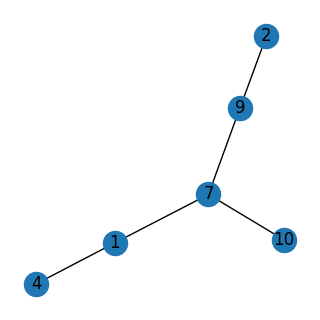

In [85]:
plot_graph(G.subgraph(neighbors))

In [87]:
removed_nodes

[8, 5, 0]

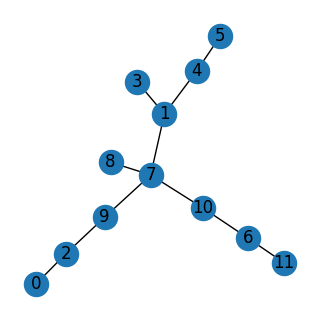

In [86]:
plot_graph(G)

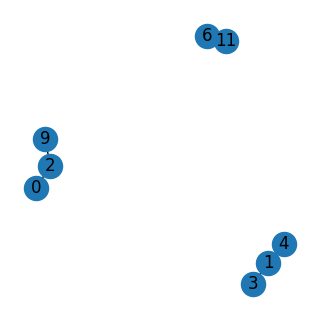

In [89]:
plot_graph(G.subgraph([0, 2, 9, 6, 11, 3, 1, 4]))

In [92]:
# This works even if the graph is not connected
# Node2Vec(G.subgraph([0, 2, 9, 6, 11, 3, 1, 4]))

In [29]:
sizes = [10, 10, 25]
probs = [[0.25, 0.05, 0.02], [0.05, 0.35, 0.07], [0.02, 0.07, 0.40]]

G = nx.stochastic_block_model(sizes, probs, seed=0)

## Testing Wikipedia .mat file

In [ ]:
data = scipy.io.loadmat('datasets/wikipedia/POS.mat')

matrix0 = data['network'].astype('float32')

In [ ]:
data

In [ ]:
data['group']

In [ ]:
data['group'].toarray()

In [ ]:
matrix0

In [ ]:
4777**2